This file implements the testing for this model

In [192]:
import tensorflow as tf
import numpy as np

from model.model_init import PITGAN

from data_processing.basic_synthetic_dataset import generate_basic_2D
from data_processing.data_transformer import DataTransformer, place_discrete, move_continuous, reverte_continuous

from visualizations.scatter_plots import plot_2D_data
from visualizations.training_loss_plots import plot_losses

from model.model_helpers import get_latent_dims

from evaluation.privacy import compute_TCAP
from evaluation.utility import compute_ROC, compute_CIO, compute_pMSE, compute_CIO_folds
from evaluation.evaluation_helpers import calculate_features

Next we load in the synthetic training data for the basic 2D example and then plot the output

In [2]:
# First we initialize the distribution for the basic example
cats = [0.2, 0.5, 0.3]
cat_names = ['small', 'medium', 'large']
mu = [[0, 0], [2, 2.1], [4.5, 4.6]]
sig = [
    [[0.05, 0], [0, 0.02]],  # Mode1: Much narrower and taller
    [[0.3, 0.15], [0.15, 0.3]],  # Mode2: Wider and more tilted
    [[0.1, -0.08], [-0.08, 0.1]]  # Mode3: Moderate width but with a significant tilt in the opposite direction
]

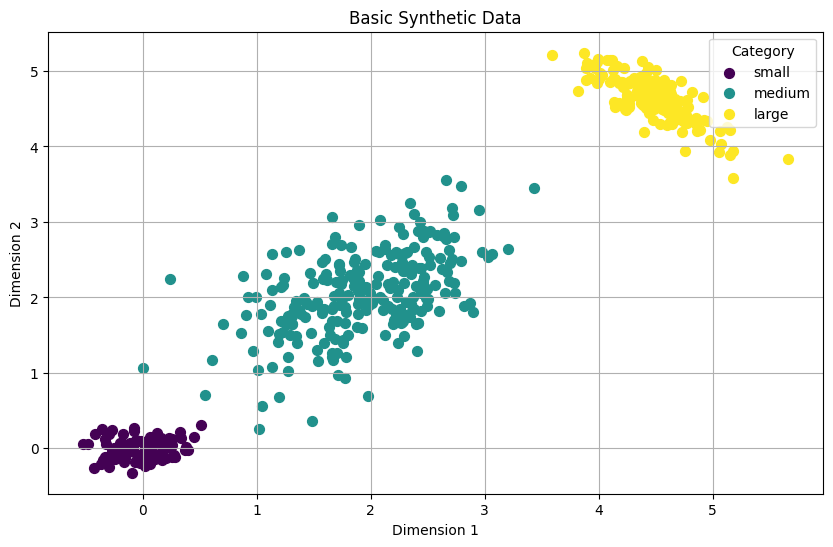

In [3]:
# Draw samples and plot them
plot_examples = generate_basic_2D(cats, cat_names, mu, sig, 500)

plot_2D_data(plot_examples, 'Basic Synthetic Data')

Next we need to apply the transformer to this data

In [7]:
train = generate_basic_2D(cats, cat_names, mu, sig, 500)
train_synth = generate_basic_2D(cats, cat_names, mu, sig, 500)

# Then we train the DataTransformer to learn
basic_transformer = DataTransformer()
basic_transformer.fit(train, ['Category'])

# Store the dimensions of the fitted data, and reorder the continuous data
D_list, C_list = basic_transformer.get_relevant_dimensions()

D_list, C_list

([3], [3, 3])

In [8]:
train = generate_basic_2D(cats, cat_names, mu, sig, 1500)
train_synth = generate_basic_2D(cats, cat_names, mu, sig, 1500)

In [10]:
TCAP = compute_TCAP(train, train_synth, [['Category']], basic_transformer, 0.95)

TCAP

,Variable,TCAP,Num_Keys
0,C_1,0.992788,1-keys
1,C_2,0.985271,1-keys


In [11]:
TCAP_new = compute_TCAP(train, train_synth, [['Category']], basic_transformer, 0.95)

TCAP_new

c:\Users\olsda\OneDrive\Documents\NU classes\Year 4\MMSS Thesis\PITGAN Implenetation\Code\evaluation\privacy.py:91: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  synth_group = data_synth.groupby(keys + [target]).size().reset_index(name='count_synth')
c:\Users\olsda\OneDrive\Documents\NU classes\Year 4\MMSS Thesis\PITGAN Implenetation\Code\evaluation\privacy.py:92: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  real_group = data_real.groupby(keys + [target]).size().reset_index(name='count_real')
c:\Users\olsda\OneDrive\Documents\NU classes\Year 4\MMSS Thesis\PITGAN Implenetation\Code\evaluation\privacy.py:91: F

,Variable,TCAP,Num_Keys
0,C_1,0.992788,1-keys
1,C_2,0.985271,1-keys


Next define the model to be used for this simple example

In [132]:
# Initialize the inputs for the model
hidden_dimensions = {
    'dim_e': [128, 64, 32],
    'dim_r': [32, 64, 128],
    'dim_g': [254, 254, 254],
    'dim_c': [254, 254, 254],
}
parameters = {
    'alpha_sup': 5, # balances sup and unsup loss for generator 
    'alpha_grad': 3, # balances gradient pen in critic loss
    'grad_step_autoencoding': 0.001,
    'grad_step_generator': 0.0001,
    'grad_step_critic': 0.001,
    'batch_size': 500,
    'sigmoid_temp': 0.3,
    'softmax_temp': 0.3,
    'critic_steps': 5,
    'scale_continuous': 2,
    'scale_noise': 1,
    'scale_discrete': 2,
    'R': 5
}

PITGAN_model = PITGAN(0, hidden_dimensions, parameters, basic_transformer)

Next we summarize the model and check if it compiles

In [7]:
# Make sure all of the layers are properly made
PITGAN_model.get_summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, 12)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cat_slice_1         │ (None, 3)         │          0 │ encoder_input[0]… │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mode_slice_1        │ (None, 5)         │          0 │ encoder_input[0]… │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mode_slice_2        │ (None, 4)         │          0 │ encoder_input[0]… │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cat_embed_1 (Dense) │ (None, 2)         │          8 │ cat_slice_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mode_embed_1        │ (None, 4)         │         24 │ mode_slice_1[0][… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mode_embed_2        │ (None, 3)         │         15 │ mode_slice_2[0][… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embed_concat        │ (None, 9)         │          0 │ cat_embed_1[0][0… │
│ (Concatenate)       │                   │            │ mode_embed_1[0][… │
│                     │                   │            │ mode_embed_2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ hidden_layer1       │ (None, 128)       │      1,280 │ embed_concat[0][… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ hidden_layer2       │ (None, 64)        │      8,256 │ hidden_layer1[0]… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ hidden_layer3       │ (None, 32)        │      2,080 │ hidden_layer2[0]… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_logits       │ (None, 2)         │         66 │ hidden_layer3[0]… │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 11,729 (45.82 KB)

 Trainable params: 11,729 (45.82 KB)

 Non-trainable params: 0 (0.00 B)

None
###################################################################


Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_latent        │ (None, 2)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ hidden_layer_1      │ (None, 32)        │         96 │ input_latent[0][… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ hidden_layer_2      │ (None, 64)        │      2,112 │ hidden_layer_1[0… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ hidden_layer_3      │ (None, 128)       │      8,320 │ hidden_layer_2[0… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cat_output_1        │ (None, 3)         │        387 │ hidden_layer_3[0… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mode_output_1       │ (None, 5)         │        645 │ hidden_layer_3[0… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mode_output_2       │ (None, 4)         │        516 │ hidden_layer_3[0… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_concat       │ (None, 12)        │          0 │ cat_output_1[0][… │
│ (Concatenate)       │                   │            │ mode_output_1[0]… │
│                     │                   │            │ mode_output_2[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 12,076 (47.17 KB)

 Trainable params: 12,076 (47.17 KB)

 Non-trainable params: 0 (0.00 B)

None
###################################################################


Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_noise         │ (None, 5)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ noise_scaled        │ (None, 5)         │          0 │ input_noise[0][0] │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_latent        │ (None, 2)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_concat        │ (None, 7)         │          0 │ noise_scaled[0][… │
│ (Concatenate)       │                   │            │ input_latent[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ hidden_concat_1     │ (None, 9)         │          0 │ input_concat[0][… │
│ (Concatenate)       │                   │            │ input_latent[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ hidden_layer_1      │ (None, 254)       │      2,540 │ hidden_concat_1[… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ hidden_concat_2     │ (None, 256)       │          0 │ hidden_layer_1[0… │
│ (Concatenate)       │                   │            │ input_latent[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ hidden_layer_2      │ (None, 254)       │     65,278 │ hidden_concat_2[… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ hidden_concat_3     │ (None, 256)       │          0 │ hidden_layer_2[0… │
│ (Concatenate)       │                   │            │ input_latent[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ hidden_layer_3      │ (None, 254)       │     65,278 │ hidden_concat_3[… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_logits       │ (None, 12)        │      3,060 │ hidden_layer_3[0… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_continuous   │ (None, 2)         │        510 │ hidden_layer_3[0… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_concat       │ (None, 14)        │          0 │ output_logits[0]… │
│ (Concatenate)       │                   │            │ output_continuou… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 136,666 (533.85 KB)

 Trainable params: 136,666 (533.85 KB)

 Non-trainable params: 0 (0.00 B)

None
###################################################################


Model: "critic"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_raw           │ (None, 14)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mode_slice_1        │ (None, 5)         │          0 │ input_raw[0][0]   │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mode_slice_2        │ (None, 4)         │          0 │ input_raw[0][0]   │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cat_slice_1         │ (None, 3)         │          0 │ input_raw[0][0]   │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mode_slice_scaled_1 │ (None, 5)         │          0 │ mode_slice_1[0][… │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cont_slice_1        │ (None, 1)         │          0 │ input_raw[0][0]   │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mode_slice_scaled_2 │ (None, 4)         │          0 │ mode_slice_2[0][… │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cont_slice_2        │ (None, 1)         │          0 │ input_raw[0][0]   │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cat_slice_scaled_1  │ (None, 3)         │          0 │ cat_slice_1[0][0] │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ continuous_concat_1 │ (None, 6)         │          0 │ mode_slice_scale… │
│ (Concatenate)       │                   │            │ cont_slice_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ continuous_concat_2 │ (None, 5)         │          0 │ mode_slice_scale… │
│ (Concatenate)       │                   │            │ cont_slice_2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cat_embed_1 (Dense) │ (None, 2)         │          8 │ cat_slice_scaled… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mode_embed_1        │ (None, 5)         │         35 │ continuous_conca… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mode_embed_2        │ (None, 4)         │         24 │ continuous_conca… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_discrete_sli… │ (None, 12)        │          0 │ input_raw[0][0]   │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_latent        │ (None, 2)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_concat        │ (None, 25)        │          0 │ cat_embed_1[0][0… │
│ (Concatenate)       │                   │            │ mode_embed_1[0][

 Total params: 137,990 (539.02 KB)

 Trainable params: 137,990 (539.02 KB)

 Non-trainable params: 0 (0.00 B)

None


In [8]:
PITGAN_model.compile()

Next we train the model. This consists of first training the encoder decoder, then the generative network. 

In [71]:
# Train the encoder and decoder network parts
losses_autoencoder = PITGAN_model.fit_autoencoder(train, 75)

---Starting Autoencoder Training
Epoch 0: Reconstruction Loss = 1.0916239023208618
Epoch 1: Reconstruction Loss = 1.0804105997085571
Epoch 2: Reconstruction Loss = 1.0673381090164185
Epoch 3: Reconstruction Loss = 1.0498496294021606
Epoch 4: Reconstruction Loss = 1.0314596891403198
Epoch 5: Reconstruction Loss = 1.009461522102356
Epoch 6: Reconstruction Loss = 0.986718475818634
Epoch 7: Reconstruction Loss = 0.9638690948486328
Epoch 8: Reconstruction Loss = 0.9150357246398926
Epoch 9: Reconstruction Loss = 0.8864527344703674
Epoch 10: Reconstruction Loss = 0.8313023447990417
Epoch 11: Reconstruction Loss = 0.7820510268211365
Epoch 12: Reconstruction Loss = 0.7352568507194519
Epoch 13: Reconstruction Loss = 0.6914203763008118
Epoch 14: Reconstruction Loss = 0.6535617709159851
Epoch 15: Reconstruction Loss = 0.6234931349754333
Epoch 16: Reconstruction Loss = 0.6063123941421509
Epoch 17: Reconstruction Loss = 0.593350887298584
Epoch 18: Reconstruction Loss = 0.5822487473487854
Epoch 19: R

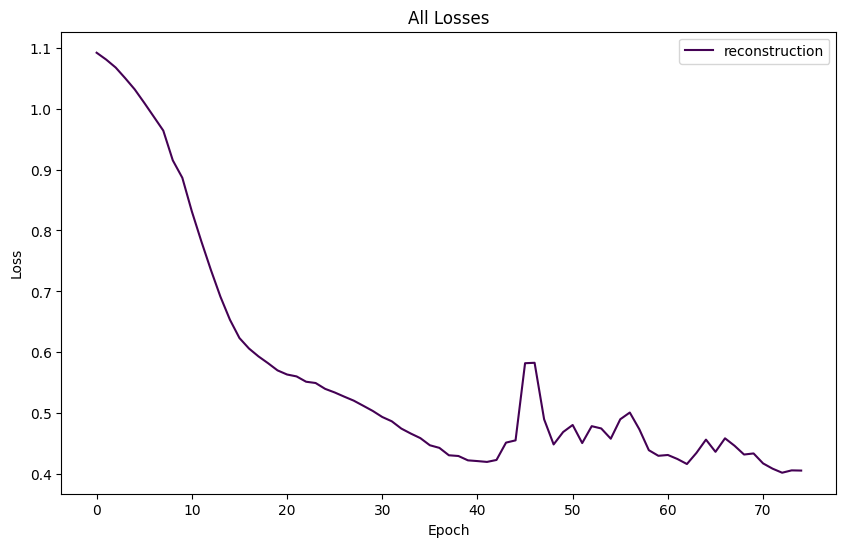

In [72]:
# plot the losses
plot_losses(losses_autoencoder, False)

In [11]:
decoded = PITGAN_model.get_decoded(train)

ROC = compute_ROC(train, decoded, basic_transformer)

ROC

,Variable,ROC
0,Category,1.000000
1,C_1,0.787846
2,C_2,0.927551


In [133]:
# train the generative parts of the network
losses_generative = PITGAN_model.fit_generative(train, 400)

---Starting Generative Training
Epoch 0: Supervised Loss = nan Unsupervised Loss G = -0.27590253949165344 Unsupervised Loss C = 0.6247959733009338 Gradient Penalty = 0.12680213153362274
Epoch 1: Supervised Loss = nan Unsupervised Loss G = -0.16786141693592072 Unsupervised Loss C = 1.4126676321029663 Gradient Penalty = 0.05786607787013054
Epoch 2: Supervised Loss = nan Unsupervised Loss G = -0.1380709409713745 Unsupervised Loss C = 1.6801072359085083 Gradient Penalty = 0.060352105647325516
Epoch 3: Supervised Loss = nan Unsupervised Loss G = -0.2101161628961563 Unsupervised Loss C = 1.7214767932891846 Gradient Penalty = 0.05853910744190216
Epoch 4: Supervised Loss = nan Unsupervised Loss G = -0.20270054042339325 Unsupervised Loss C = 1.7237032651901245 Gradient Penalty = 0.05724823474884033
Epoch 5: Supervised Loss = nan Unsupervised Loss G = -0.18776126205921173 Unsupervised Loss C = 1.7205625772476196 Gradient Penalty = 0.056511733680963516
Epoch 6: Supervised Loss = nan Unsupervised 

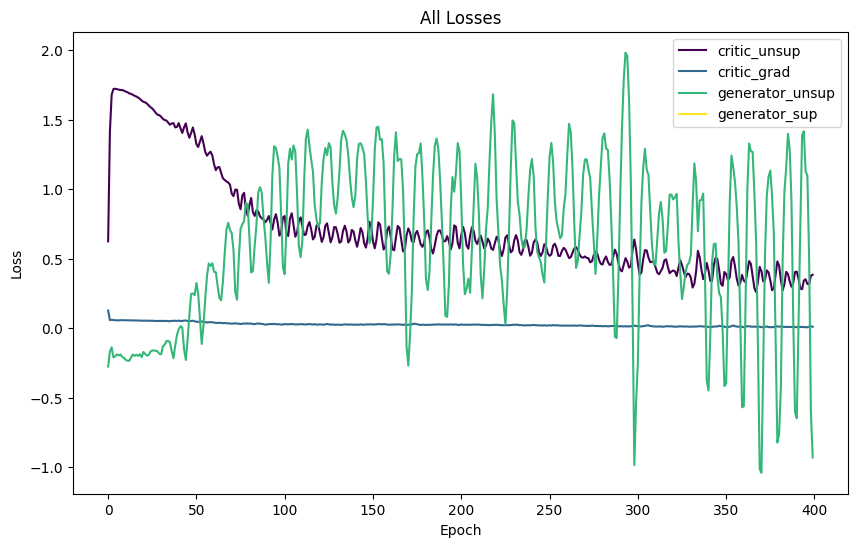

In [134]:
# Plot the losses
plot_losses(losses_generative, False)

Now that the model has been trained we are able to start running inferences on it. First we retransform the data back to the form we can use. Then we plot it in comparison to the real data.

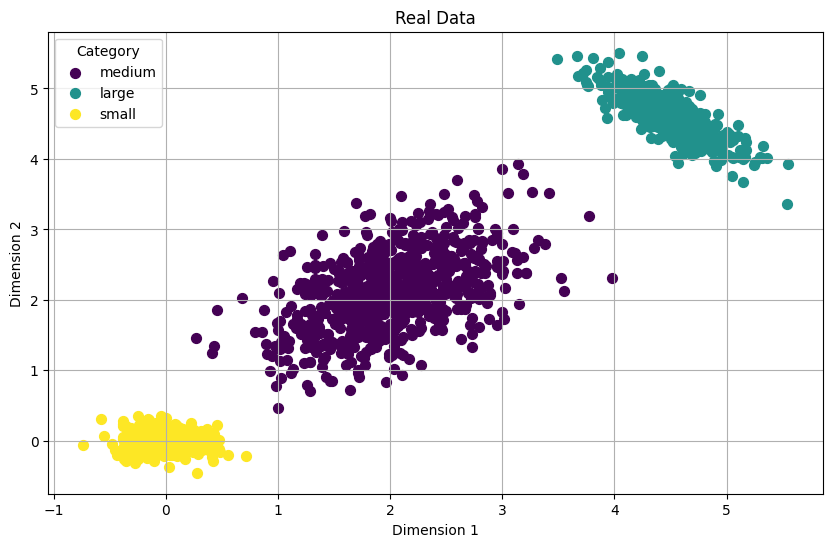

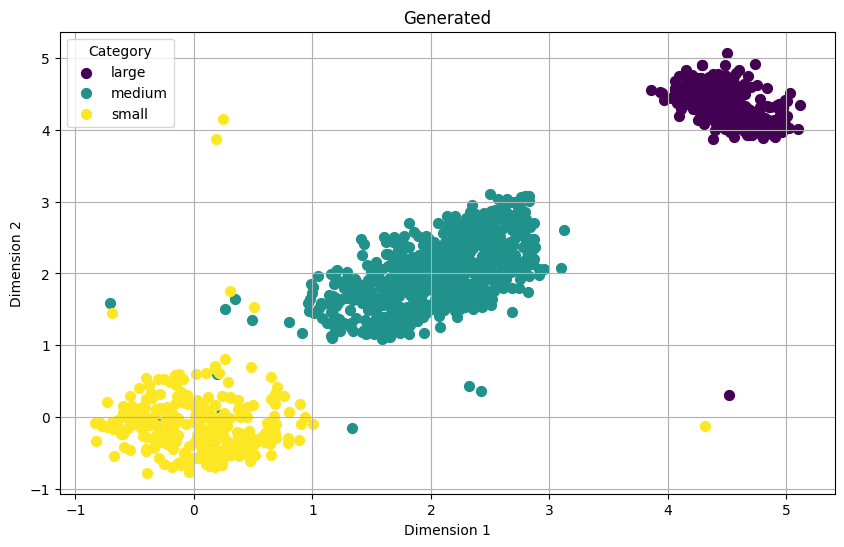

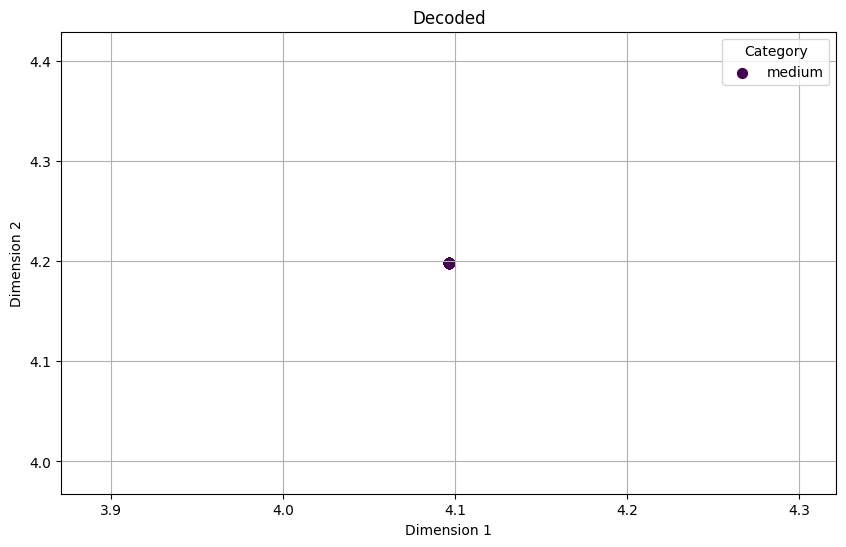

In [195]:
# plot the real data
plot_2D_data(train, 'Real Data')

generated = PITGAN_model.generate(train, 1)

# plot the generated data
plot_2D_data(generated, "Generated")

decoded = PITGAN_model.get_decoded(train)

# plot the decoded data
plot_2D_data(decoded, 'Decoded')

In [11]:
from evaluation.evaluation_procedure import evaluate
from visualizations.scatter_plots import plot_priv_utility

regressions = {
    'Dim_1': (['Dimension_1'],['Dimension_2'],['Category']),
    'Dim_2': (['Dimension_2'],['Dimension_1'],['Category'])
}

results = evaluate(train, PITGAN_model, basic_transformer, ['Category'], [0.33,0.33,0.33], [['Category']], regressions)

results

0.9929552428482222


,Latent_dim,Decoded_ROC,ROC,CIO,pMSE,PMSE4,Utility,1-keys
0,2,0.677306,0.749002,0.0,0.151088,0.395648,0.377734,0.992955


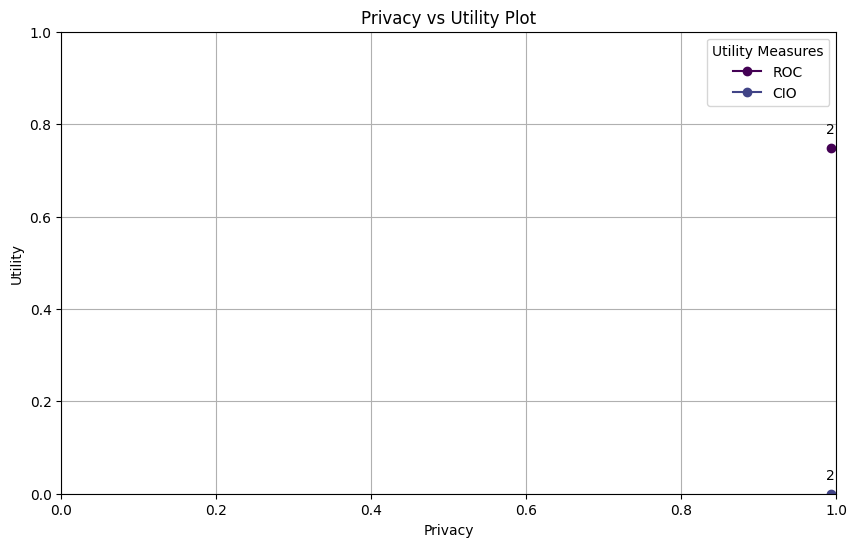

In [14]:
from visualizations.scatter_plots import plot_priv_utility_new

plot_priv_utility_new(results, False, '1-keys', ['ROC','CIO'])

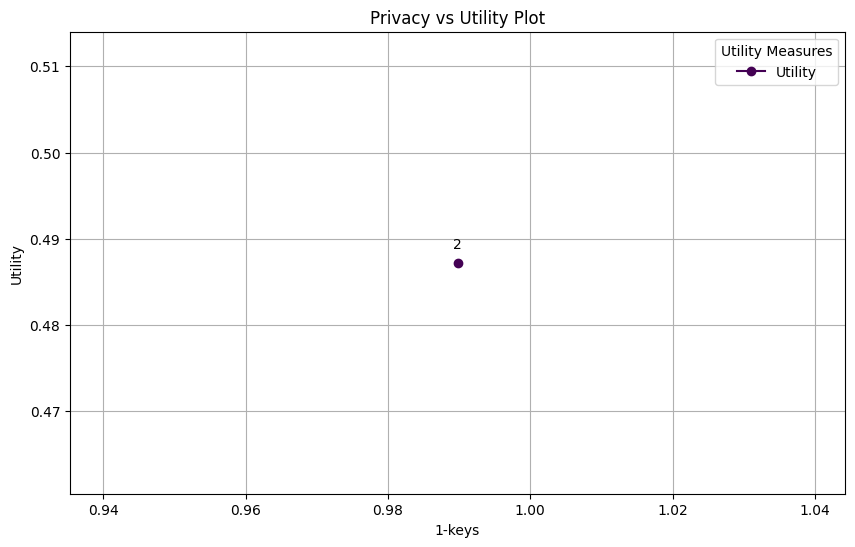

In [13]:
plot_priv_utility(results, True, '1-keys', ['ROC','CIO'])

In [14]:
results

,Latent_dim,Decoded_ROC,ROC,CIO,pMSE,PMSE4,Utility,1-keys
0,2,0.990256,0.860038,0.0,0.125183,0.499268,0.487219,0.989786


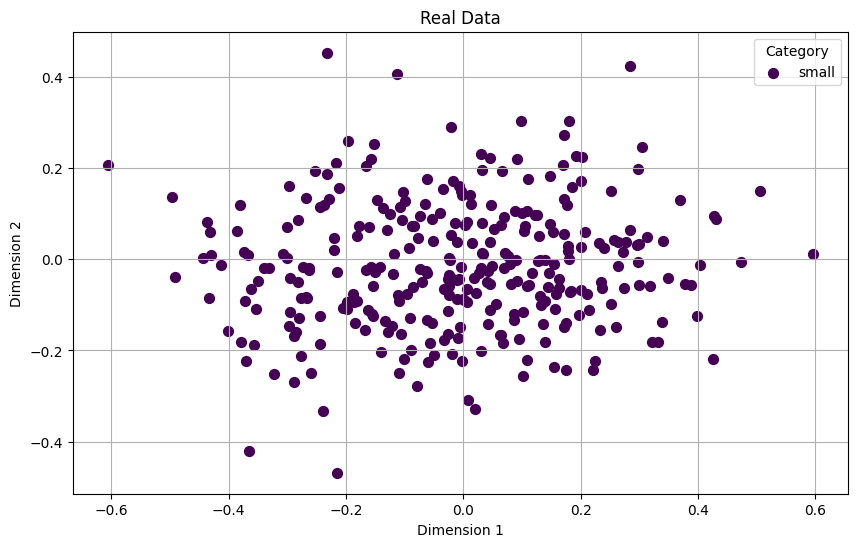

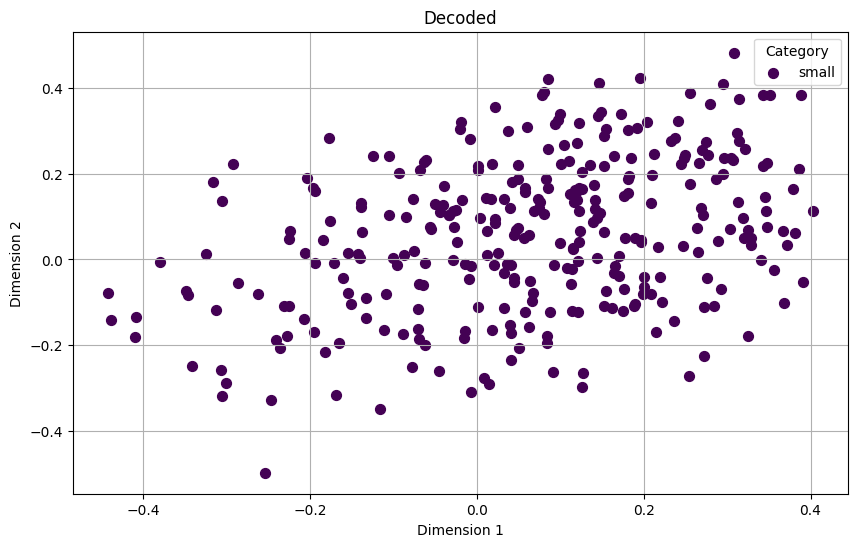

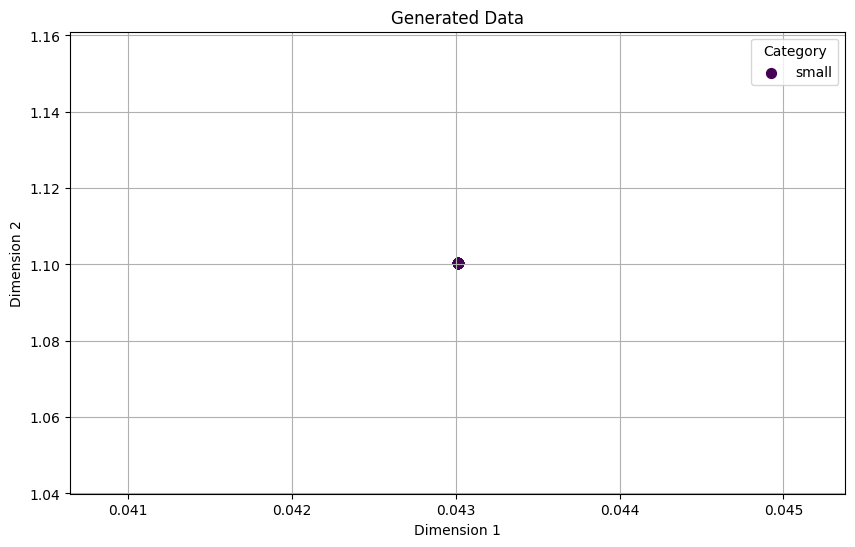

In [142]:
# Subset the data for the least abundant class
new_train = train[train['Category']=='small']

# plot the real data
plot_2D_data(new_train, 'Real Data')

generated = PITGAN_model.generate(new_train, 1)

decoded = PITGAN_model.get_decoded(new_train)

# plot the generated data
plot_2D_data(generated, "Decoded")

# plot the decoded data
plot_2D_data(decoded, 'Generated Data')

In [195]:
train[train['Dimension_1']<5].head(10)

,Dimension_1,Dimension_2,Category
0,1.299869,1.983355,medium
1,4.583398,4.324774,large
2,2.896607,2.544401,medium
3,4.290601,4.719594,large
4,4.230841,5.351188,large
5,2.460527,2.683647,medium
6,4.558457,4.489044,large
7,4.612989,4.420114,large
8,2.333095,2.747201,medium
9,-0.424743,0.183584,small


In [217]:
subset = train

In [197]:
subset_fake = PITGAN_model.generate(subset,  1)

subset_fake = basic_transformer.transform(subset_fake)

Y_fake = PITGAN_model.get_latent(subset_fake, True)

Y_fake

<tf.Tensor: shape=(1500, 1), dtype=float32, numpy=
array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]], dtype=float32)>

In [218]:
subset_real = basic_transformer.transform(subset)

Y = PITGAN_model.get_latent(subset_real, True)

Y

<tf.Tensor: shape=(1500, 2), dtype=float32, numpy=
array([[1., 0.],
       [0., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [0., 0.]], dtype=float32)>

In [201]:
import pandas as pd

In [34]:
Y_test = pd.DataFrame(Y, columns=["Latent_1"])

sum(Y_test['Latent_1'])

NameError: name 'Y' is not defined

In [176]:
len(decoded[(decoded['Category']=='medium') & (decoded['Dimension_1']>3.7)])

55

In [175]:
len(generated[(generated['Category']=='large') & (generated['Dimension_1']>3.7)& (generated['Dimension_2']<3.5)] )

54

Next Run the same model but without the latent space

In [196]:
ROC = compute_ROC(train, generated, basic_transformer)

CIO = compute_CIO(train, generated, ['Dimension_1'], ['Dimension_2'], [ 'Category'])

TCAP = compute_TCAP(train, generated, [['Category']], basic_transformer, 0.95)

pMSE = compute_pMSE(train, generated, ['Category'])

c:\Users\olsda\OneDrive\Documents\NU classes\Year 4\MMSS Thesis\PITGAN Implenetation\Code\evaluation\privacy.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  synth_group = data_synth.groupby(keys + [target]).size().reset_index(name='count_synth')
c:\Users\olsda\OneDrive\Documents\NU classes\Year 4\MMSS Thesis\PITGAN Implenetation\Code\evaluation\privacy.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  real_group = data_real.groupby(keys + [target]).size().reset_index(name='count_real')
c:\Users\olsda\OneDrive\Documents\NU classes\Year 4\MMSS Thesis\PITGAN Implenetation\Code\evaluation\privacy.py:23: F

In [202]:
# Specify the regressions to be sued for CIO evaluation
regressions = {
    'Dim_1': (['Dimension_1'],['Dimension_2'],['Category']),
    'Dim_2': (['Dimension_2'],['Dimension_1'],['Category'])
}

CIOs = compute_CIO_folds(train, PITGAN_model, regressions, 5)

CIOs

,Regression,Variable,CIO
0,Dim_1,const,0.167069
1,Dim_1,Dimension_2,0.036515
2,Dim_1,Category_medium,0.112069
3,Dim_1,Category_small,0.045196
4,Dim_2,const,0.036248
5,Dim_2,Dimension_1,0.352291
6,Dim_2,Category_medium,0.119225
7,Dim_2,Category_small,0.249848


In [197]:
CIO

,Variable,CIO
0,const,0.256554
1,Dimension_2,0.078086
2,Category_medium,0.136617
3,Category_small,0.043286


In [15]:
TCAP = compute_TCAP(train, generated, [['Category']], basic_transformer, 0.95)

TCAP

,Variable,TCAP,Num_Keys
0,C_1,0.577296,1-keys
1,C_2,0.979499,1-keys


In [48]:
decoded = PITGAN_model.get_decoded(train)

decoded_modes = basic_transformer.transform_modes(decoded)
train_modes = basic_transformer.transform_modes(train)

In [53]:
modes_pMSE = compute_pMSE(train_modes, decoded_modes, ['Category', 'C_1', 'C_2'])

modes_pMSE

(0.05523981292323746, 0.7790407483070502)

In [34]:
# Initialize the inputs for the model
hidden_dimensions = {
    'dim_e': [50, 30, 20],
    'dim_r': [20, 30, 50],
    'dim_g': [200, 200, 200],
    'dim_c': [200, 200, 200],
}
parameters = {
    'alpha_sup': 10, # balances sup and unsup loss for generator 
    'alpha_grad': 3, # balances gradient pen in critic loss
    'grad_step_autoencoding': 0.001,
    'grad_step_generator': 0.001,
    'grad_step_critic': 0.001,
    'critic_steps': 5,
    'batch_size': 100,
    'sigmoid_temp': 0.3,
    'softmax_temp': 0.3,
    'critic_steps': 5,
    'scale_continuous': 2,
    'scale_noise': 2,
    'scale_discrete': 2,
    'decay_rate': 0.9,
    'decay_steps': 25
}

WGAN_model = PITGAN(0, hidden_dimensions, parameters, basic_transformer)

In [35]:
# Run generative training
losses_generative_WGAN = WGAN_model.fit_generative(train, 100)

---Starting Generative Training
Epoch 0: Supervised Loss = nan Unsupervised Loss G = -0.23955771327018738 Unsupervised Loss C = 0.830424964427948 Gradient Penalty = 0.1018359586596489
Epoch 1: Supervised Loss = nan Unsupervised Loss G = -0.383328914642334 Unsupervised Loss C = 1.525842308998108 Gradient Penalty = 0.06920838356018066
Epoch 2: Supervised Loss = nan Unsupervised Loss G = -0.500058650970459 Unsupervised Loss C = 1.5408661365509033 Gradient Penalty = 0.06038229167461395
Epoch 3: Supervised Loss = nan Unsupervised Loss G = -0.3049606680870056 Unsupervised Loss C = 1.4475948810577393 Gradient Penalty = 0.05782180279493332
Epoch 4: Supervised Loss = nan Unsupervised Loss G = -0.3866352438926697 Unsupervised Loss C = 1.7012145519256592 Gradient Penalty = 0.0667799785733223
Epoch 5: Supervised Loss = nan Unsupervised Loss G = -0.7245061993598938 Unsupervised Loss C = 1.895279884338379 Gradient Penalty = 0.08161486685276031
Epoch 6: Supervised Loss = nan Unsupervised Loss G = -0.

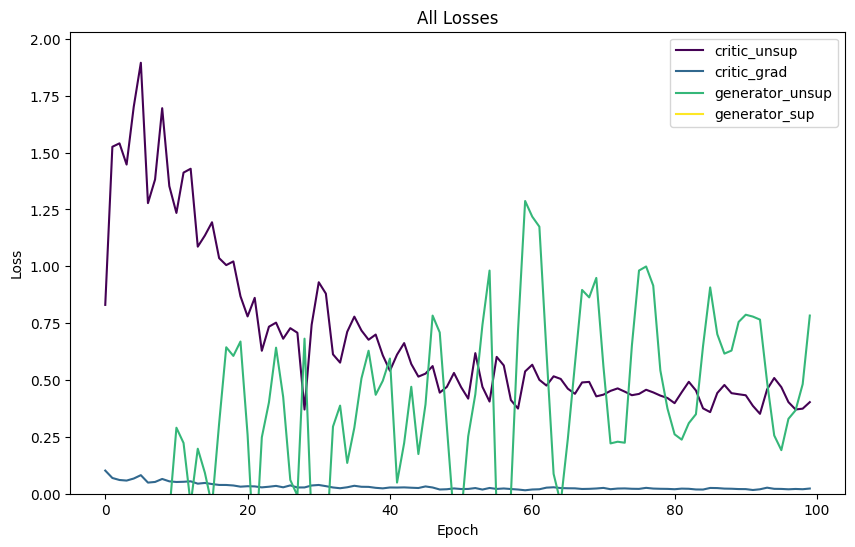

In [36]:
# Plot losses
plot_losses(losses_generative_WGAN, False)

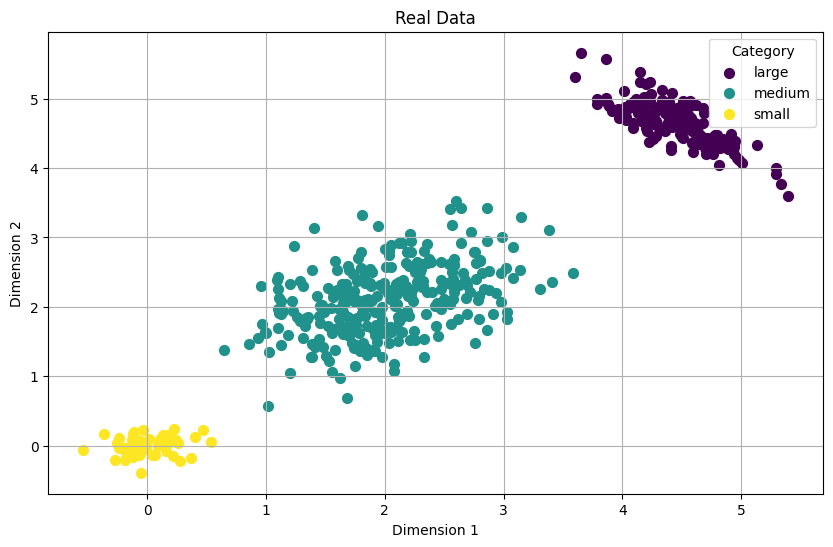

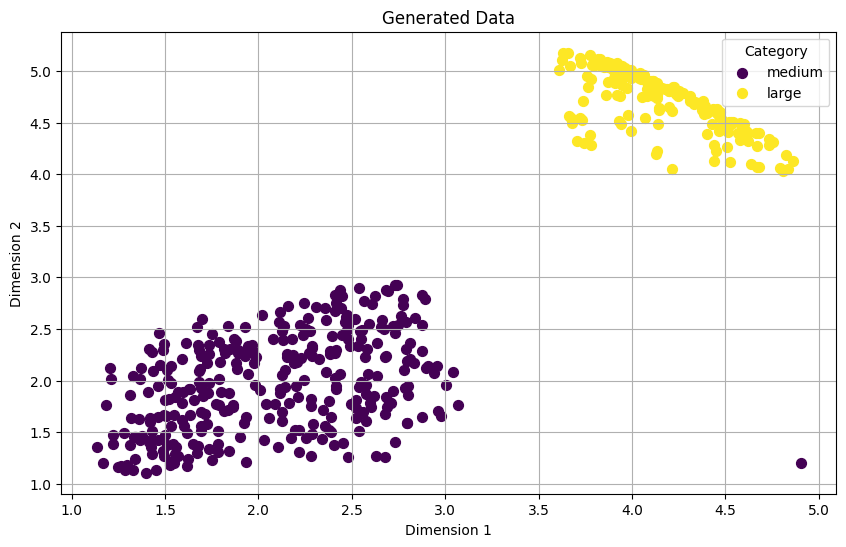

In [37]:
# plot the real data
plot_2D_data(train, 'Real Data')

generated_WGAN = WGAN_model.generate(train, 1)

# plot the generated data
plot_2D_data(generated_WGAN, 'Generated Data')

Next check how the evaluation metrics are working

In [35]:
from evaluation.privacy import compute_TCAP
from evaluation.utility import compute_ROC, compute_CIO, compute_pMSE

In [36]:
train_modes = basic_transformer.transform_modes(generated)

train_modes.head()

UnboundLocalError: cannot access local variable 'data_cat' where it is not associated with a value

,p1,p2
0,1,4
1,1,5
2,1,6
3,2,4
4,2,5
5,2,6
6,3,4
7,3,5
8,3,6


In [5]:
from itertools import product
import pandas as pd
parameters = {'p1':[1,2,3], 'p2':[4,5,6]}
pps = {'p1':0, 'p2':0}

combinations = list(product(*parameters.values()))
grid = pd.DataFrame(combinations, columns=parameters.keys())

# Next we perform the unsupervised training for each of the parameters in the grid
for index, params in grid.iterrows():

    # Set the model parameters based on the parameters selected
    for param in grid.columns:
                
        pps[param] = params[param]

pps

{'p1': 3, 'p2': 6}

Testing

In [103]:
import pandas as pd

In [108]:
data = pd.read_csv('C:/Users/olsda/OneDrive/Documents/NU classes/Year 4/MMSS Thesis/PITGAN Implenetation/Data/usa_00001/census_clean_2019.csv')

In [110]:
data = data.sample(25000)

data.head()

,REGION,SEX,MARST,RACE,CITIZEN,EDUC,HEALTHCOV,EMPSTAT,POVERTY,INCTOT,FAMSIZE,AGE
2180411,West,Male,Widowed,White,Yes,High_School,Pub_Cov,Not_in_LaborF,Above,51800,1,84
1180691,Midwest,Female,Separated,White,Yes,High_School,Pub_Cov,Employed,Above,10000,2,63
698777,West,Male,Married,White,Yes,Bachelors,Priv_Cov,Employed,Above,20000,6,35
1840007,Norhteast,Male,Married,White,Yes,High_School,Priv_Cov,Employed,Above,38000,2,54
332389,West,Male,Married,White,Yes,High_School,No_Cov,Employed,Above,56000,2,55


In [111]:
data.to_csv('C:/Users/olsda/OneDrive/Documents/NU classes/Year 4/MMSS Thesis/PITGAN Implenetation/Data/usa_00001/census_clean_subset_25000.csv', index=False)